In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

In [5]:
sales = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
item_cat = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')
test = pd.read_csv('test.csv')

In [6]:
#formating the dates properly.
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


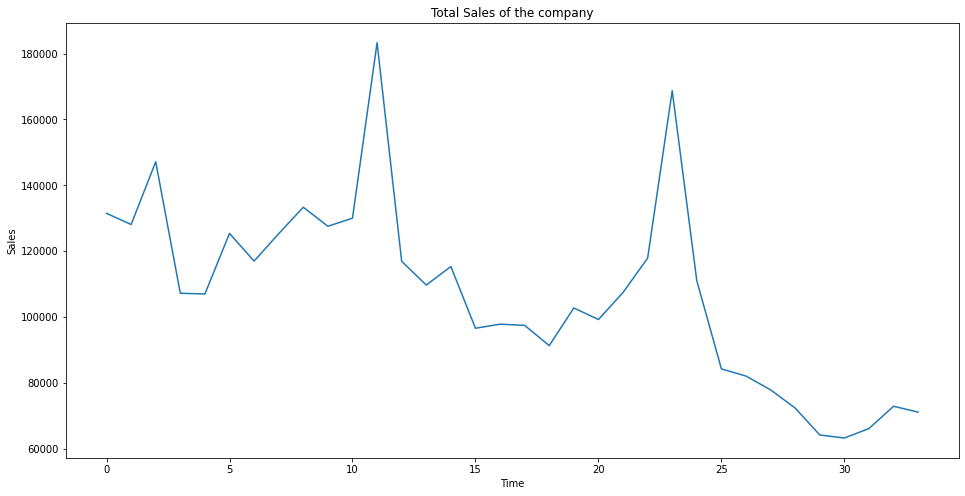

In [46]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

In [47]:
from statsmodels.tsa.stattools import adfuller
def rolling(time):
    rolmean = time.rolling(window = 12, center = False).mean()
    rolstd = time.rolling(window = 12, center = False).std()
    
    plt.figure(figsize = (10,10))
    plt.plot(time)
    plt.plot(rolmean,'b', label = 'Rolling Mean')
    plt.plot(rolstd, 'r', label = 'ROlling STD')
    plt.legend()
    
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(time, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


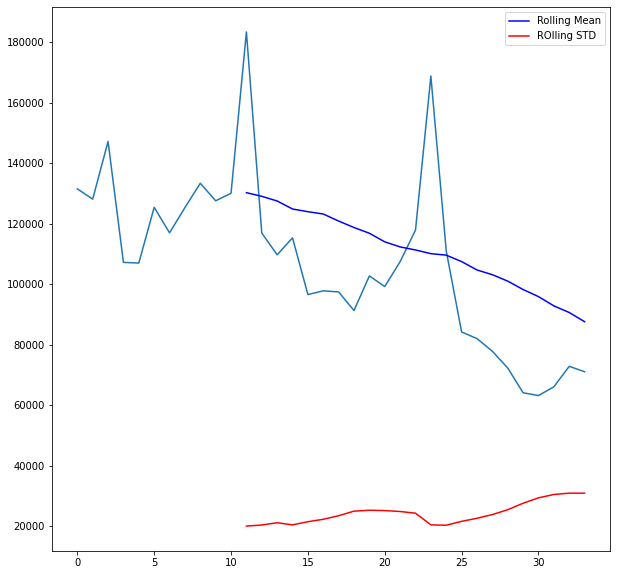

In [48]:
rolling(ts)

<ipython-input-49-979025faf33a>:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")


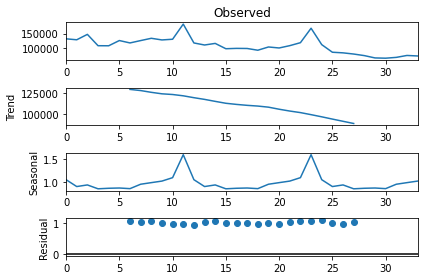

In [49]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

<ipython-input-50-8acf724c32e6>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")


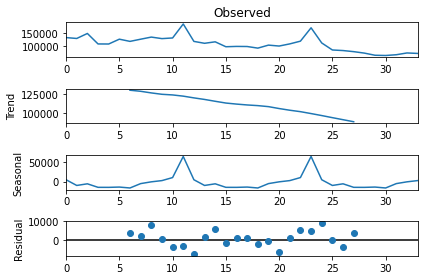

In [50]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()